In [1]:
import astroprov
from astropy.io import fits
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

import numpy as np
from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
from astropy.table import Column

import collections
import subprocess

In [2]:
imagedirectory = '/home/mj1e16/keplerImages'

newImagelist = []
Image = os.listdir(imagedirectory)
for i, item in enumerate(Image):
    if item.find('.fits') != -1:
        #print(i,Image[i].find('.fits'))
        newImagelist.append(item)
Image = newImagelist


FWHM = 5.0
MinSep = 0.8 #sets value for discriminating sources
N = len(Image) #number of images minus 1 as it starts from zero
imno = 0
imagedata = []
sources = dict()
Date = []
STD = []
Median = []


os.chdir(imagedirectory)
def daoStarFinder(imagename):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    #print(Image[imagenumber])
    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
    Median.append(median)
    STD.append(std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
    output[1] = Date
    output[2] = imagedata
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (output[0]['xcentroid'], output[0]['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.savefig('fits.png',dpi=100)
    plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [3]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    print(world)
    return(world)
#     # Convert the same coordinates back to pixel coordinates.
#     pixcrd2 = w.wcs_world2pix(world, 1)
#     print(pixcrd2)

#     # These should be the same as the original pixel coordinates, modulo
#     # some floating-point error.
#     assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6




In [4]:
def queryObjectRegion(outputTable,imageName,inCat):
    imageCoords = []
    r = 1*u.arcminute
    
    if inCat == 'dao':
        xlabel = 'xcentroid'
        ylabel = 'ycentroid'
        label = 'id'
        
    if inCat == 'sex':
        xlabel = 'X_IMAGE'
        ylabel = 'Y_IMAGE'
        label = 'NUMBER'
        
    tableLength = outputTable[label][-1]
    for x in range(tableLength):
        xpos = outputTable[xlabel][x]
        ypos = outputTable[ylabel][x]
        if 20 < ypos < 1040:
            if 12 < xpos < 1110:
                imageCoords.append([xpos,ypos])
                # this may need to change per image but I hope not

    coords = load_wcs_from_file(imageName,imageCoords)
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))

    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            result_table.add_row(rowlist)

        except:
            result_table.add_row(['N/A',[0],[0],'Possible Transient',[imageCoords[x][0]],[imageCoords[x][1]]])
    
    hdu_list = fits.open(imageName)
    imagedata = (hdu_list[0].data) 
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (outputTable[xlabel], outputTable[ylabel])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    
    return result_table

In [5]:
def sextractor(sextractoryDir,imagename,cataloguename):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')

    os.chdir('/home/mj1e16/keplerImages/')
    hdu_list = fits.open(imagename[:-3]) # open image header
    imagedata = (hdu_list[0].data) 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (assoc['X_IMAGE'], assoc['Y_IMAGE'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    return assoc

In [6]:
def foundInBoth(daoTable,sexTable):
    
    daox = daoTable['xcentroid'].tolist()
    daox = [round(x,2) for x in doax]
    daoy = daoTable['ycentroid'].tolist()
    daoy = [round(x,2) for x in doay]
    daocoords = zip(daox,daoy)
    
    sexx = sexTable['xcentroid'].tolist()
    sexx = [round(x,2) for x in sexx]
    sexy = sexTable['ycentroid'].tolist()
    sexy = [round(x,2) for x in sexy]
    sexcoords = zip(sexx,sexy)
    
    commonIndicies = [i for x,i in enumerate(daocoords) if x in sexcoords]
    return commonIndicies

In [7]:
imageName = 'difkplr2009115080620_ffi-cal57.fits[0]'

In [8]:
print(imageName[:-3])

difkplr2009115080620_ffi-cal57.fits


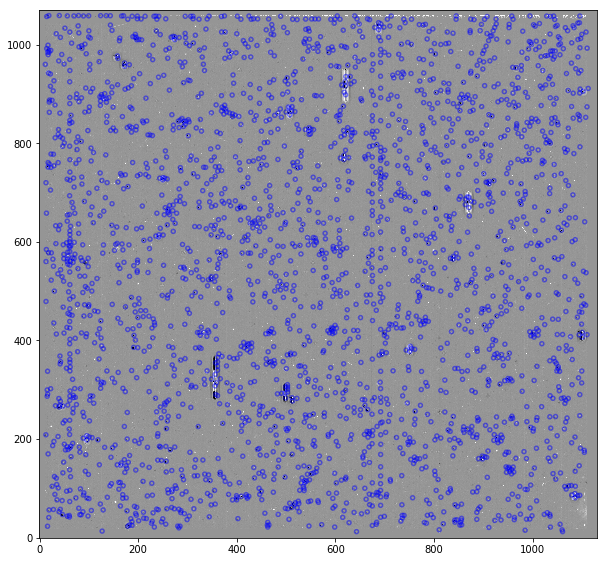

In [9]:
sextable = sextractor('/home/mj1e16/sextractor/sextractor-master/config/','difkplr2009115080620_ffi-cal57.fits[0]','test.cat')

In [10]:
sources = {}
Date = {}
imagedata = {}
N = 1
for x in range(N):
    output = daoStarFinder(imageName)
    sources[x] = output[0]
    Date[x] = output[1]
    imagedata[x] = output[2]
#os.chdir(bindingsdirectory) 

IOError: [Errno 2] No such file or directory: 'difkplr2009115080620_ffi-cal57.fits[0]'

In [ ]:
output = daoStarFinder(x)
sources[x] = output[0]
Date[x] = output[1]
imagedata[x] = output[2]

In [11]:
coords = load_wcs_from_file(dirlist[1],imageCoords)

NameError: name 'dirlist' is not defined

In [12]:
customSimbad = Simbad()
customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
customSimbad.remove_votable_fields('coordinates')

In [88]:
result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))
c = SkyCoord(coords[0][0],coords[0][1],frame='icrs',unit='deg')
rt = customSimbad.query_region(c,radius=r)

rowlist = []
for x in range(len(rt[0])):
    rowlist.append(rt[0][x])
rowlist.append(imageCoords[0][0])
rowlist.append(imageCoords[0][1])

result_table.add_row(rowlist)

In [106]:
r = 1*u.arcminute
result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))

for x in range(len(coords)):
    try:
        c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
        rt = customSimbad.query_region(c,radius=r)
        rowlist = []
        for x in range(len(rt[0])):
            rowlist.append(rt[0][x])
        rowlist.append(imageCoords[x][0])
        rowlist.append(imageCoords[x][1])
        result_table.add_row(rowlist)
        
    except:
        result_table.add_row([['N/A'],[0],[0],'Possible Transient',[imageCoords[x][0]],[imageCoords[x][1]]])


In [108]:
result_table['OTYPE']

-
RGB*
Star
Star
Star
Star
Star
Eruptive*
RGB*
Eruptive*
Star


In [73]:
result_table = Table([['N/A'],['N/A'],['N/A'],['Possible Transient'],[imageCoords[x][0]],[imageCoords[x][1]]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))


c = SkyCoord(coords[0][0],coords[0][1],frame='icrs',unit='deg')
result_table = customSimbad.query_region(c,radius=r)
result_table = result_table[0]
xcolumn = Column([imageCoords[x][0]],name='xcentroid')
result_table.add_column(xcolumn,index=0)
ycolumn = Column([imageCoords[x][1]],name='ycentroid')
result_table.add_column(ycolumn,index=0)

AttributeError: 'Row' object has no attribute 'add_column'

In [64]:
r = 1*u.arcminute

for x in range(len(coords)):
    if x == 0:
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            result_table = customSimbad.query_region(c,radius=r)
            xcolumn = Column([imageCoords[x][0]],name='xcentroid')
            ycolumn = Column([imageCoords[x][1]],name='ycentroid')
            result_table.add_column(xcolumn,index=-1)
            result_table.add_column(ycolumn,index=-1)
        except:
            result_table = Table([['N/A'],['N/A'],['N/A'],['Possible Transient'],[imageCoords[x][0]],[imageCoords[x][1]]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'))
    else:
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            result_table.add_row([rt[0][0],rt[0][1],rt[0][2],rt[0][3],imageCoords[x][0],imageCoords[x][1]])
        except:
            result_table.add_row([['N/A'],['N/A'],['N/A'],['Possible Transient'],[imageCoords[x][0]],[imageCoords[x][1]]])


In [41]:
result_table.add_row([0,0,0,0])

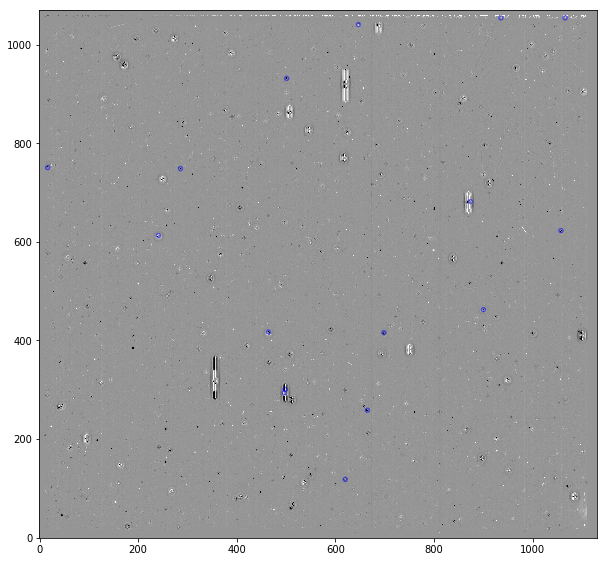

In [30]:
hdu_list = fits.open(Image[0])
imagedata = (hdu_list[0].data) 
fig, ax = plt.subplots(figsize=(10, 10))
positions = (df2['xcentroid'], df2['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
#plt.savefig('fits.png',dpi=100)
plt.show()



[[293.5787304   47.74496033]
 [293.13821043  47.56749714]
 [293.65059772  47.77641567]
 ...
 [293.35680197  48.96731172]
 [292.45961724  48.60947896]
 [292.28011989  48.53615779]]
[[597.6233512613425, 20.15880520487267], [910.6143403168055, 20.970033989267286], [545.4766473925444, 22.18647280771546], [354.25688563260917, 25.533997621700365], [690.9898124571824, 29.93690728807214], [841.4058779949274, 29.950427588222173], [855.7220569154483, 33.47881096561611], [841.3475074896459, 34.61172145685849], [922.5092473775792, 34.026529270172226], [687.8029191125012, 35.92991383874445], [1034.8780323603257, 36.133052295086294], [215.89691909408577, 37.344714899948016], [248.97083539712125, 36.86971043525276], [184.28550872738066, 37.276313880328125], [60.02187298631989, 41.00347490416009], [963.0918763944987, 40.21398549075858], [966.3388806548021, 39.43164435035686], [482.98846424228105, 45.832568918535436], [1103.746685034214, 49.79859848698939], [103.86813943874166, 53.91546647240631], [28

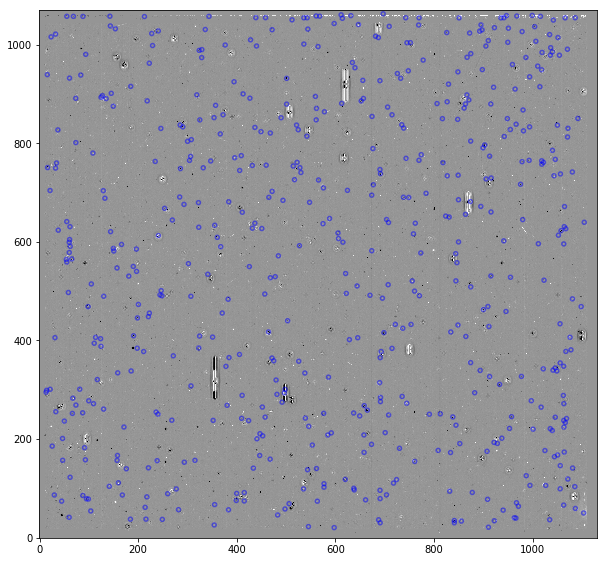

In [198]:
result_table = queryObjectRegion(output[0],dirlist[1],'dao')

In [202]:
sextable

NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,FLUX_APER,FLUXERR_APER,FLUX_RADIUS,FWHM_IMAGE,BACKGROUND,THRESHOLD,FLUX_MAX,ISOAREA_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS
,pix,pix,deg,deg,ct,ct,pix,pix,ct,ct,ct,pix2,pix,pix,deg,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64
1,366.6358,322.2338,293.6506535,48.1623527,417.3166,7.891025,116.734,28.22,-0.009481637,2.665454,36.84732,339,19.456,1.136,89.88,2
2,348.8325,321.5395,293.6765695,48.1717656,440.0486,7.891025,-22.24,28.26,-0.0138404,2.665454,39.72083,331,20.098,1.103,89.94,0
3,691.8074,41.2232,293.4282818,47.7114591,72.02734,7.883018,11.568,19.46,0.027369,2.665454,16.07449,55,9.846,1.068,-89.49,18
4,1079.6274,86.3401,292.8463348,47.5322136,229.7125,7.891025,1.425,29.36,0.03194002,2.665454,54.66074,189,9.1,2.629,85.17,19
5,1091.4449,84.9291,292.8310394,47.5240795,178.5781,7.875002,-0.736,12.14,0.02308891,2.665454,63.61269,41,4.558,0.901,81.44,3
6,733.0027,33.4281,293.37691,47.68064,32.24888,7.875002,0.894,0.0,-0.01118747,2.665454,22.32013,1,0.76,0.495,-1.41,0
7,179.0251,22.8606,294.1694206,47.9832547,752.5048,7.899024,1.131,8.82,0.1052659,2.665454,382.7975,25,1.795,1.21,-39.15,3
8,1060.9999,11.9999,292.9355768,47.4728061,27.20446,7.858947,0.428,0.0,-0.01762908,2.665454,26.88603,1,0.578,0.578,-0.28,0



[[293.65065355  48.16235276]
 [293.67656946  48.17176563]
 [293.42828183  47.71145916]
 ...
 [292.38982893  48.56232899]
 [292.28612166  48.49729151]
 [292.63600579  48.58261722]]


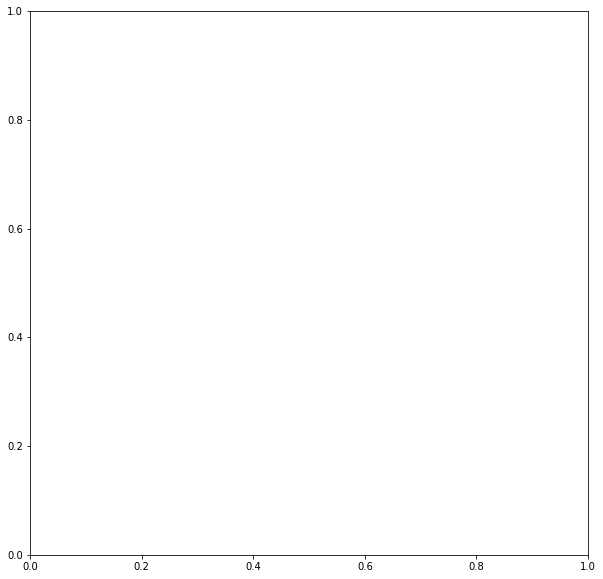

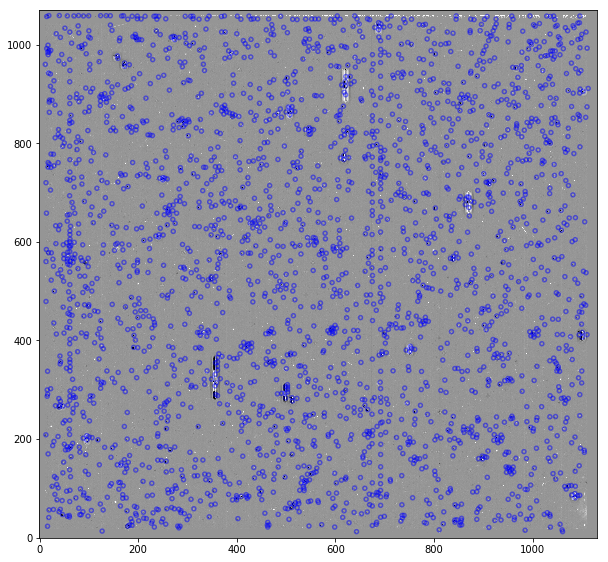

In [210]:
result_table = queryObjectRegion(sextable,dirlist[1],'sex')

In [223]:
result_table

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid
object,float64,float64,object,float64,float64
-,0.0,0.0,-,0.0,0.0
HD 184977,293.6660859272987,48.1645481089252,Eruptive*,366.6358,322.2338
HD 184977,293.6660859272987,48.1645481089252,Eruptive*,348.8325,321.5395
2MASS J19334818+4742223,293.4507506162486,47.7061907421516,Star,691.8074,41.2232
TYC 3560-2641-1,292.8366575316853,47.5266373176776,Star,1079.6274,86.3401
TYC 3560-2641-1,292.8366575316853,47.5266373176776,Star,1091.4449,84.9291
KIC 10474113,293.379753684899,47.690825837556,RotV*,733.0027,33.4281
TYC 3560-2338-2,294.1674535393339,47.9848105125714,Eruptive*,179.0251,22.8606
TYC 3560-2338-1,294.1641649460618,47.9832010453427,Star,182.1615,25.3024


In [156]:
outtable = result_table

In [222]:
len(result_table)

2494

In [211]:
otype = result_table['OTYPE']

In [212]:
otype

-
Eruptive*
Eruptive*
Star
Star
Star
RotV*
Eruptive*
Star
Star
RGB*


In [213]:
otypelist = []
for x in range(len(otype)):
    otypelist.append(otype[x])
print(len(otypelist))

2494


In [214]:
newotype = set(otypelist)

In [215]:
newotype

{'-',
 'Cepheid',
 'EB*',
 'EB*Algol',
 'EB*WUMa',
 'EB*betLyr',
 'EllipVar',
 'Eruptive*',
 'Galaxy',
 'HotSubdwarf',
 'IR>30um',
 'Inexistent',
 'LPV*',
 'Mira',
 'PM*',
 'Planet',
 'Planet?',
 'Possible Transient',
 'PulsV*delSct',
 'RGB*',
 'Radio',
 'RotV*',
 'Star',
 'V*',
 'WD*',
 'X',
 'gammaDor',
 'low-mass*'}

In [216]:
counter = collections.Counter(otypelist)

In [217]:
print(counter.values())

[1, 2, 15, 1, 1, 12, 1, 4, 1477, 4, 6, 6, 284, 1, 2, 7, 432, 2, 1, 135, 28, 38, 4, 1, 5, 5, 1, 18]


In [218]:
print(counter.keys())

['-', 'Inexistent', 'EB*', 'EB*betLyr', 'low-mass*', 'PulsV*delSct', 'EB*WUMa', 'IR>30um', 'Star', 'V*', 'EB*Algol', 'Mira', 'RotV*', 'HotSubdwarf', 'EllipVar', 'Planet?', 'Possible Transient', 'Planet', 'X', 'RGB*', 'PM*', 'Eruptive*', 'Cepheid', 'WD*', 'LPV*', 'Radio', 'gammaDor', 'Galaxy']


In [219]:
def findObjectOccurences(inputTable,columnName):
    otype = inputTable[columnName]
    otypelist = []
    for x in range(len(otype)):
        otypelist.append(otype[x])
    #print(len(otypelist))
    newotype = set(otypelist)
    counter = collections.Counter(otypelist)
    keys = counter.keys()
    values = counter.values()
    occurenceDict = dict(zip(keys,values))
    return occurenceDict

In [220]:
otypes = findObjectOccurences(result_table,'OTYPE')

In [221]:
otypes

{'-': 1,
 'Cepheid': 4,
 'EB*': 15,
 'EB*Algol': 6,
 'EB*WUMa': 1,
 'EB*betLyr': 1,
 'EllipVar': 2,
 'Eruptive*': 38,
 'Galaxy': 18,
 'HotSubdwarf': 1,
 'IR>30um': 4,
 'Inexistent': 2,
 'LPV*': 5,
 'Mira': 6,
 'PM*': 28,
 'Planet': 2,
 'Planet?': 7,
 'Possible Transient': 432,
 'PulsV*delSct': 12,
 'RGB*': 135,
 'Radio': 5,
 'RotV*': 284,
 'Star': 1477,
 'V*': 4,
 'WD*': 1,
 'X': 1,
 'gammaDor': 1,
 'low-mass*': 1}

In [225]:
newlist = result_table['xcentroid'].tolist()

In [227]:
newlist

[0.0,
 366.6358,
 348.8325,
 691.8074,
 1079.6274,
 1091.4449,
 733.0027,
 179.0251,
 182.1615,
 1036.3268,
 547.6262,
 284.9689,
 187.6526,
 232.7804,
 784.8369,
 572.2427,
 280.2689,
 691.7881,
 842.7467,
 1055.9645,
 675.0,
 853.9238,
 16.1505,
 911.473,
 923.4915,
 598.6497,
 462.9503,
 255.9854,
 461.907,
 546.5484,
 692.0053,
 682.9864,
 1095.9003,
 228.6093,
 780.4562,
 819.0176,
 856.2612,
 852.6787,
 465.3492,
 226.9124,
 691.891,
 627.7748,
 683.6776,
 462.8896,
 187.4319,
 247.4038,
 249.9165,
 846.4883,
 842.2812,
 201.0316,
 855.7255,
 813.9498,
 813.9249,
 813.9661,
 813.9287,
 402.3794,
 962.9573,
 46.5946,
 735.968,
 887.0041,
 210.706,
 798.7018,
 185.0815,
 936.0701,
 739.4382,
 856.044,
 299.1609,
 516.6285,
 1029.933,
 786.6791,
 994.5063,
 987.6941,
 1035.7291,
 614.9917,
 216.5874,
 507.2154,
 999.0074,
 344.1506,
 211.2921,
 506.0095,
 511.6563,
 56.1756,
 699.5122,
 963.314,
 18.6666,
 194.824,
 84.3911,
 60.5518,
 814.0033,
 735.5823,
 60.301,
 303.6653,
 98.24